In [ ]:
from google.colab import files
uploaded = files.upload()


Saving 02 Churn-Dataset.xlsx to 02 Churn-Dataset.xlsx


In [ ]:
import pandas as pd

# Load the Excel file
file_path = "02 Churn-Dataset.xlsx"  # Make sure the filename matches exactly
df = pd.read_excel(file_path)

# Display first few rows
print(df.head())


   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... StreamingTV  \
0  No phone service             DSL             No  ...          No   
1                No             DSL            Yes  ...          No   
2                No             DSL            Yes  ...          No   
3  No phone service             DSL            Yes  ...          No   
4                No     Fiber optic             No  ...          No   

  StreamingMovies        Contract PaperlessBilling              PaymentMethod  \
0          

In [ ]:
import pandas as pd

# ✅ 1. Clean `Churn` Column
df['Churn'] = df['Churn'].astype(str).str.strip()  # Remove spaces
df['Churn'] = df['Churn'].replace({'': None, ' ': None, 'nan': None})  # Replace empty values
df.dropna(subset=['Churn'], inplace=True)  # Drop rows with missing Churn values
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})  # Convert to binary

# ✅ 2. Drop Irrelevant Columns
df.drop(columns=['customerID'], inplace=True)  # Drop customerID (not useful for training)

# ✅ 3. Convert `TotalCharges` to Numeric & Fill Missing Values
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')  # Convert to float
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)  # Fill missing values

# ✅ 4. Identify Categorical Features
categorical_features = df.select_dtypes(include=['object']).columns
print("✅ Categorical Columns:", categorical_features)

# ✅ 5. Convert Binary Columns (Yes/No → 0/1)
binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
df['gender'] = df['gender'].map({'Female': 1, 'Male': 0})  # Female → 1, Male → 0

for col in binary_cols[1:]:  # Skip 'gender' as it's already handled
    df[col] = df[col].map({'Yes': 1, 'No': 0})

# ✅ 6. Convert `MultipleLines`
df['MultipleLines'] = df['MultipleLines'].map({'No': 0, 'Yes': 1, 'No phone service': 0})

# ✅ 7. One-Hot Encode Categorical Features (`drop_first=True` avoids redundancy)
df = pd.get_dummies(df, columns=['InternetService', 'Contract', 'PaymentMethod'], drop_first=True)

# ✅ 8. Convert Internet-Related Features (Yes/No/No internet service → 0/1)
internet_features = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
for col in internet_features:
    df[col] = df[col].map({'Yes': 1, 'No': 0, 'No internet service': 0})

# ✅ 9. Convert Entire Dataset to Numeric Type
df = df.astype(int)

# ✅ 10. Verify Preprocessing
print("✅ Missing values in dataset:\n", df.isnull().sum())  # Should be 0
print("\n✅ Data types:\n", df.dtypes)  # Ensure all columns are numeric
print("\n✅ Final shape of dataset:", df.shape)  # Confirm number of features

# ✅ Save Processed Data (Optional)
df.to_csv("processed_dataset.csv", index=False)
print("✅ Preprocessed dataset saved successfully!")


✅ Categorical Columns: Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object')
✅ Missing values in dataset:
 gender                                   0
SeniorCitizen                            0
Partner                                  0
Dependents                               0
tenure                                   0
PhoneService                             0
MultipleLines                            0
OnlineSecurity                           0
OnlineBackup                             0
DeviceProtection                         0
TechSupport                              0
StreamingTV                              0
StreamingMovies                          0
PaperlessBilling                         0
MonthlyCharges                           0
TotalCharges

<ipython-input-3-c7fc8fcc452e>:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)  # Fill missing values


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
import pickle

# ✅ Split Features and Target
X = df.drop(columns=['Churn'])
y = df['Churn']

# ✅ Train-Test Split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("✅ Train-Test Split Complete!")

✅ Train-Test Split Complete!


In [ ]:
pip install catboost scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.3 MB/s eta 0:00:00


In [ ]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from catboost import CatBoostClassifier
import numpy as np

# ✅ 1. Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate Random Forest
rf_y_pred = rf_model.predict(X_test)
rf_y_pred_prob = rf_model.predict_proba(X_test)[:, 1]

rf_accuracy = accuracy_score(y_test, rf_y_pred)
rf_auc = roc_auc_score(y_test, rf_y_pred_prob)
print("Random Forest Performance:")
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"AUC-ROC: {rf_auc:.4f}")
print(classification_report(y_test, rf_y_pred))

# ✅ 2. Train CatBoost
catboost_model = CatBoostClassifier(iterations=100, learning_rate=0.1, random_seed=42, verbose=0)
catboost_model.fit(X_train, y_train)

# Predict and evaluate CatBoost
catboost_y_pred = catboost_model.predict(X_test)
catboost_y_pred_prob = catboost_model.predict_proba(X_test)[:, 1]

catboost_accuracy = accuracy_score(y_test, catboost_y_pred)
catboost_auc = roc_auc_score(y_test, catboost_y_pred_prob)
print("\nCatBoost Performance:")
print(f"Accuracy: {catboost_accuracy:.4f}")
print(f"AUC-ROC: {catboost_auc:.4f}")
print(classification_report(y_test, catboost_y_pred))

# ✅ 3. Create an Ensemble with Soft Voting
ensemble_model = VotingClassifier(
    estimators=[('rf', rf_model), ('catboost', catboost_model)],
    voting='soft'
)
ensemble_model.fit(X_train, y_train)

# Predict and evaluate Ensemble
ensemble_y_pred = ensemble_model.predict(X_test)
ensemble_y_pred_prob = ensemble_model.predict_proba(X_test)[:, 1]

ensemble_accuracy = accuracy_score(y_test, ensemble_y_pred)
ensemble_auc = roc_auc_score(y_test, ensemble_y_pred_prob)
print("\nEnsemble (RF + CatBoost) Performance:")
print(f"Accuracy: {ensemble_accuracy:.4f}")
print(f"AUC-ROC: {ensemble_auc:.4f}")
print(classification_report(y_test, ensemble_y_pred))

# ✅ 4. Compare Model Performances
print("\nModel Comparison:")
print(f"Random Forest: Accuracy = {rf_accuracy:.4f}, AUC-ROC = {rf_auc:.4f}")
print(f"CatBoost: Accuracy = {catboost_accuracy:.4f}, AUC-ROC = {catboost_auc:.4f}")
print(f"Ensemble: Accuracy = {ensemble_accuracy:.4f}, AUC-ROC = {ensemble_auc:.4f}")


Random Forest Performance:
Accuracy: 0.8559
AUC-ROC: 0.9171
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      1035
           1       0.76      0.66      0.71       374

    accuracy                           0.86      1409
   macro avg       0.82      0.79      0.81      1409
weighted avg       0.85      0.86      0.85      1409


CatBoost Performance:
Accuracy: 0.8652
AUC-ROC: 0.9373
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      1035
           1       0.78      0.69      0.73       374

    accuracy                           0.87      1409
   macro avg       0.83      0.81      0.82      1409
weighted avg       0.86      0.87      0.86      1409


Ensemble (RF + CatBoost) Performance:
Accuracy: 0.8609
AUC-ROC: 0.9318
              precision    recall  f1-score   support

           0       0.89      0.92      0.91      1035
           1       0.77      0.68      0.72      

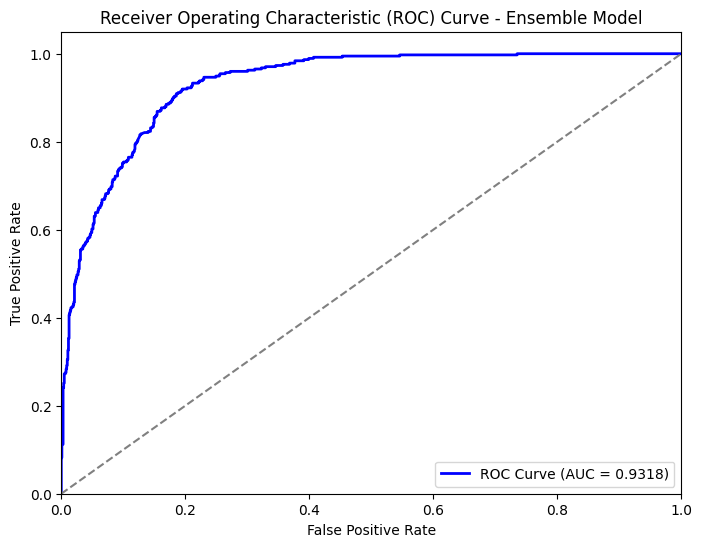

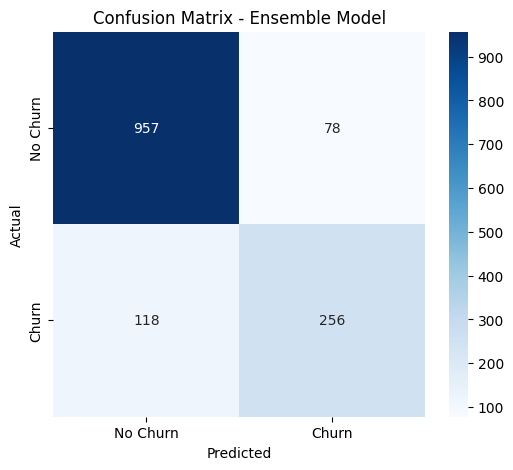

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix

# ✅ Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, ensemble_y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Ensemble Model')
plt.legend(loc='lower right')
plt.show()

# ✅ Plot Confusion Matrix
cm = confusion_matrix(y_test, ensemble_y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Ensemble Model')
plt.show()


In [ ]:
import pickle
from google.colab import files

# ✅ Save the Ensemble Model
with open('model3.pkl', 'wb') as file:
    pickle.dump(ensemble_model, file)

# ✅ Download the Pickle File
files.download('model3.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>